In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
import time
warnings.filterwarnings("ignore")

# Data Preprocessing

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
customer = pd.read_csv("data/customer.csv")
customeraccount = pd.read_csv("data/customeraccount.csv")
genel_kategoriler = pd.read_csv("data/genel_kategoriler.csv")
product_groups = pd.read_csv("data/product_groups.csv")
transaction_header = pd.read_csv("data/transaction_header.csv")
transaction_sale = pd.read_csv("data/transaction_sale.csv")

In [3]:
train

,individualnumber,category_number,hakkedis_amt,odul_amt,response
0,94230288,9000,21.0,2.0,0
1,4684087,9000,17.0,1.0,0
2,92472145,9058,24.0,3.0,0
3,88026681,9030,22.0,2.0,0
4,98127795,9001,38.0,3.0,0
...,...,...,...,...,...
13110,97214433,9059,27.0,2.0,0
13111,96841665,9004,65.0,6.0,0
13112,98445787,9044,33.0,3.0,0
13113,13781030,9004,66.0,6.0,0


In [4]:
customer

,individualnumber,gender,city_code,dateofbirth
0,94212124,K,NaN,1946.0
1,96387515,E,34.0,1974.0
2,95040383,E,80.0,1980.0
3,94694434,E,NaN,1970.0
4,47648671,E,35.0,1963.0
...,...,...,...,...
28588,94368469,K,34.0,1948.0
28589,90691477,E,7.0,1990.0
28590,95834384,E,22.0,1970.0
28591,92199848,E,34.0,1985.0


In [5]:
t_c = pd.merge(train, customer, how="left")
t_c

,individualnumber,category_number,hakkedis_amt,odul_amt,response,gender,city_code,dateofbirth
0,94230288,9000,21.0,2.0,0,E,7.0,1983.0
1,4684087,9000,17.0,1.0,0,E,19.0,1951.0
2,92472145,9058,24.0,3.0,0,K,35.0,1982.0
3,88026681,9030,22.0,2.0,0,K,NaN,1961.0
4,98127795,9001,38.0,3.0,0,E,9.0,1984.0
...,...,...,...,...,...,...,...,...
13110,97214433,9059,27.0,2.0,0,K,NaN,1997.0
13111,96841665,9004,65.0,6.0,0,E,7.0,1971.0
13112,98445787,9044,33.0,3.0,0,K,33.0,1975.0
13113,13781030,9004,66.0,6.0,0,E,54.0,1981.0


In [6]:
genel_kategoriler

,category_number,genel_kategori
0,9052,diger
1,9053,diger
2,9054,diger
3,9055,gida
4,9056,gida
5,9057,diger
6,9058,gida
7,9059,hijyen
8,9060,kisisel_bakim
9,9061,kisisel_bakim


In [7]:
t_c_gk = pd.merge(t_c, genel_kategoriler, how="left")
t_c_gk

,individualnumber,category_number,hakkedis_amt,odul_amt,response,gender,city_code,dateofbirth,genel_kategori
0,94230288,9000,21.0,2.0,0,E,7.0,1983.0,icecek
1,4684087,9000,17.0,1.0,0,E,19.0,1951.0,icecek
2,92472145,9058,24.0,3.0,0,K,35.0,1982.0,gida
3,88026681,9030,22.0,2.0,0,K,NaN,1961.0,kisisel_bakim
4,98127795,9001,38.0,3.0,0,E,9.0,1984.0,gida
...,...,...,...,...,...,...,...,...,...
13110,97214433,9059,27.0,2.0,0,K,NaN,1997.0,hijyen
13111,96841665,9004,65.0,6.0,0,E,7.0,1971.0,gida
13112,98445787,9044,33.0,3.0,0,K,33.0,1975.0,gida
13113,13781030,9004,66.0,6.0,0,E,54.0,1981.0,gida


In [8]:
product_groups

,category_number,category_level_1,category_level_2,category_level_3,category_level_4
0,9046,341,20,10,10
1,9009,125,25,10,10
2,9049,410,65,20,10
3,9019,300,10,19,11
4,9035,305,31,10,10
...,...,...,...,...,...
3908,9019,616,95,20,15
3909,9020,616,95,20,10
3910,9020,616,95,20,15
3911,9020,616,95,20,30


In [9]:
def quantile25(data):
    return data.quantile(0.25)
def quantile75(data):
    return data.quantile(0.75)

aggregator_dict = {}
for idx, val in enumerate(product_groups.columns[1:]):
    aggregator_dict[val] = ["min", quantile25, "median", quantile75, "max", "mean", "std"]

pg_grpd = product_groups.groupby('category_number')
pg_grpd_agg = pg_grpd.agg(aggregator_dict)
pg_grpd_agg = pg_grpd_agg.reset_index()
pg_grpd_agg

category_number category_level_1                                    \
                                min quantile25 median quantile75  max   
0             9000              103     103.00  300.0      603.0  692   
1             9001              110     110.00  110.0      609.0  609   
2             9002              125     125.00  125.0      613.0  692   
3             9003              110     110.00  110.0      609.0  649   
4             9004              110     110.00  110.0      609.0  609   
5             9005              125     125.00  302.0      302.0  613   
6             9006              103     125.00  131.0      613.0  613   
7             9007              125     125.00  125.0      613.0  613   
8             9008              125     125.00  125.0      613.0  613   
9             9009              125     125.00  310.0      613.0  613   
10            9010              110     110.00  130.0      609.0  617   
11            9011              125     125.00  313.0      539.5  696   
12            9012              125     131.00  131.0      617.0  617   
13            9015              130     130.25  131.0      616.0  648   
14            9017              130     130.00  130.0      616.0  692   
15            9018              131     131.00  131.0      617.0  617   
16            9019              130     300.00  302.0      302.0  617   
17            9020              130     130.00  131.0      302.0  616   
18            9021              200     200.00  205.0      618.0  618   
19            9022              200     200.00  210.0      618.0  624   
20            9024              200     200.00  210.0      618.0  624   
21            9027              210     210.00  210.0      624.0  624   
22            9028              130     210.00  210.0      624.0  665   
23            9029              220     225.00  225.0      225.0  628   
24            9030              220     225.00  225.0      627.0  628   
25            9031              220     225.00  225.0      627.0  628   
26            9032              210     220.00  220.0      220.0  627   
27            9035              300     300.00  300.0      300.0  649   
28            9036              310     310.00  310.0      636.0  636   
29            9037              310     313.00  313.0      644.0  644   
30            9038              310     310.00  310.0      636.0  636   
31            9039              311     311.00  311.0      639.0  639   
32            9040              131     312.00  312.0      312.0  643   
33            9041              110     335.00  335.0      335.0  643   
34            9042              331     331.00  331.0      646.0  646   
35            9043              330     330.00  330.0      645.0  645   
36            9044              125     335.00  335.0      335.0  650   
37            9046              340     340.00  340.0      340.0  643   
38            9048              220     400.00  400.0      654.0  657   
39            9049              410     410.00  425.0      657.0  665   
40            9052              130     130.00  420.0      660.0  660   
41            9053              420     420.00  420.0      660.0  670   
42            9054              420     420.00  420.0      420.0  660   
43            9055              130     505.00  505.0      515.0  696   
44            9056              313     313.00  313.0      644.0  644   
45            9057              420     425.00  425.0      660.0  670   
46            9058              110     130.00  131.0      616.0  636   
47            9059              200     205.00  205.0      621.0  621   
48            9060              220     220.00  220.0      627.0  627   
49            9061              225     225.00  225.0      225.0  628   

                           category_level_2             ... category_level_3  \
          mean         std              min quantile25  ...              max   
0   310.371429  226.234403               10   

In [10]:
columns = []
for col in pg_grpd_agg.columns:
    columns.append("-".join(col))
columns

['category_number-',
 'category_level_1-min',
 'category_level_1-quantile25',
 'category_level_1-median',
 'category_level_1-quantile75',
 'category_level_1-max',
 'category_level_1-mean',
 'category_level_1-std',
 'category_level_2-min',
 'category_level_2-quantile25',
 'category_level_2-median',
 'category_level_2-quantile75',
 'category_level_2-max',
 'category_level_2-mean',
 'category_level_2-std',
 'category_level_3-min',
 'category_level_3-quantile25',
 'category_level_3-median',
 'category_level_3-quantile75',
 'category_level_3-max',
 'category_level_3-mean',
 'category_level_3-std',
 'category_level_4-min',
 'category_level_4-quantile25',
 'category_level_4-median',
 'category_level_4-quantile75',
 'category_level_4-max',
 'category_level_4-mean',
 'category_level_4-std']

In [11]:
columns[0] = columns[0][:-1]
pg_grpd_agg.columns = columns
pg_grpd_agg

,category_number,category_level_1-min,category_level_1-quantile25,category_level_1-median,category_level_1-quantile75,category_level_1-max,category_level_1-mean,category_level_1-std,category_level_2-min,category_level_2-quantile25,...,category_level_3-max,category_level_3-mean,category_level_3-std,category_level_4-min,category_level_4-quantile25,category_level_4-median,category_level_4-quantile75,category_level_4-max,category_level_4-mean,category_level_4-std
0,9000,103,103.00,300.0,603.0,692,310.371429,226.234403,10,26.25,...,40,16.642857,8.711205,10,10.00,14.0,20.00,50,17.114286,9.862156
1,9001,110,110.00,110.0,609.0,609,346.066667,249.244408,10,10.00,...,50,17.833333,8.895184,10,15.00,25.0,32.00,60,25.900000,13.676282
2,9002,125,125.00,125.0,613.0,692,296.444444,258.175866,10,15.00,...,30,21.666667,10.000000,10,10.00,20.0,25.00,40,21.111111,11.931518
3,9003,110,110.00,110.0,609.0,649,313.416667,253.163425,20,20.00,...,35,24.583333,6.894772,10,10.00,17.5,27.50,35,20.000000,10.224747
4,9004,110,110.00,110.0,609.0,609,314.136364,251.114904,30,30.00,...,45,29.772727,12.293753,10,10.00,10.0,20.00,75,17.727273,14.534628
5,9005,125,125.00,302.0,302.0,613,292.444444,199.354026,20,20.00,...,25,20.555556,4.639804,10,20.00,55.0,60.00,65,43.333333,22.220486
6,9006,103,125.00,131.0,613.0,613,315.803922,233.864321,10,10.00,...,25,15.588235,5.162079,10,15.00,25.0,40.00,65,28.431373,14.982997
7,9007,125,125.00,125.0,613.0,613,320.200000,242.560459,15,15.00,...,25,15.857143,4.772118,10,15.00,20.0,37.50,65,26.285714,17.503901
8,9008,125,125.00,125.0,613.0,613,281.478261,227.157108,10,20.00,...,45,13.043478,7.345241,10,17.50,25.0,42.50,65,30.434783,16.645573
9,9009,125,125.00,310.0,613.0,613,357.200000,245.422493,20,25.00,...,25,13.000000,6.708204,10,10.00,10.0,15.00,15,12.000000,2.738613


In [12]:
t_c_gk_pg = pd.merge(t_c_gk, pg_grpd_agg, how = "left")
t_c_gk_pg

,individualnumber,category_number,hakkedis_amt,odul_amt,response,gender,city_code,dateofbirth,genel_kategori,category_level_1-min,...,category_level_3-max,category_level_3-mean,category_level_3-std,category_level_4-min,category_level_4-quantile25,category_level_4-median,category_level_4-quantile75,category_level_4-max,category_level_4-mean,category_level_4-std
0,94230288,9000,21.0,2.0,0,E,7.0,1983.0,icecek,103,...,40,16.642857,8.711205,10,10.00,14.0,20.0,50,17.114286,9.862156
1,4684087,9000,17.0,1.0,0,E,19.0,1951.0,icecek,103,...,40,16.642857,8.711205,10,10.00,14.0,20.0,50,17.114286,9.862156
2,92472145,9058,24.0,3.0,0,K,35.0,1982.0,gida,110,...,60,16.187500,11.906881,10,13.75,22.5,45.0,65,27.921875,17.481332
3,88026681,9030,22.0,2.0,0,K,NaN,1961.0,kisisel_bakim,220,...,50,30.882353,17.520996,10,10.00,15.0,20.0,30,15.294118,5.987119
4,98127795,9001,38.0,3.0,0,E,9.0,1984.0,gida,110,...,50,17.833333,8.895184,10,15.00,25.0,32.0,60,25.900000,13.676282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13110,97214433,9059,27.0,2.0,0,K,NaN,1997.0,hijyen,200,...,45,29.137931,10.717251,10,14.00,19.0,30.0,85,23.965517,15.540325
13111,96841665,9004,65.0,6.0,0,E,7.0,1971.0,gida,110,...,45,29.772727,12.293753,10,10.00,10.0,20.0,75,17.727273,14.534628
13112,98445787,9044,33.0,3.0,0,K,33.0,1975.0,gida,125,...,30,16.388158,5.813947,10,15.00,25.0,35.0,99,24.717105,13.214190
13113,13781030,9004,66.0,6.0,0,E,54.0,1981.0,gida,110,...,45,29.772727,12.293753,10,10.00,10.0,20.0,75,17.727273,14.534628


In [13]:
transaction_header

,date_of_transaction,cardnumber,basketid,is_sanal
0,2020-12-01,8487374630565615,20120163990041163,0
1,2020-12-01,4287574603569015,20120163990016137,0
2,2020-12-01,6487154648560315,20120160080017338,0
3,2020-12-01,3787564693563915,20120163570105022,0
4,2020-12-01,9087994683569715,20120162340016645,0
...,...,...,...,...
1124668,2021-12-01,5187224618568515,21120111950019800,0
1124669,2021-12-01,87714689568015,21120111830079927,0
1124670,2021-12-01,3287454606560415,21120110690047978,0
1124671,2021-12-01,9887854616568815,21120110000068135,0


In [14]:
ca_th = pd.merge(customeraccount, transaction_header, how = "left")
ca_th

,individualnumber,cardnumber,date_of_transaction,basketid,is_sanal
0,16481068,7287134635560315,2020-12-20,2.012201e+16,0.0
1,16481068,7287134635560315,2020-12-27,2.012271e+16,0.0
2,16481068,7287134635560315,2021-01-17,2.101174e+16,0.0
3,16481068,7287134635560315,2021-01-28,2.101281e+16,0.0
4,16481068,7287134635560315,2021-02-04,2.102046e+16,0.0
...,...,...,...,...,...
1129508,101270229,9287054697566815,2021-10-04,2.110040e+16,0.0
1129509,101270229,9287054697566815,2021-10-04,2.110040e+16,0.0
1129510,101328888,2587064608564915,2021-07-13,2.107131e+16,0.0
1129511,102040641,1587464609566715,2021-10-19,2.110197e+16,0.0


In [15]:
ca_th_ts = pd.merge(ca_th, transaction_sale, how = "left")
ca_th_ts

,individualnumber,cardnumber,date_of_transaction,basketid,is_sanal,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3
0,16481068,7287134635560315,2020-12-20,2.012201e+16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16481068,7287134635560315,2020-12-27,2.012271e+16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16481068,7287134635560315,2021-01-17,2.101174e+16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16481068,7287134635560315,2021-01-28,2.101281e+16,0.0,103.0,25.0,35.0,10.0,29.75,5.0,NaN,5.0,5.00
4,16481068,7287134635560315,2021-01-28,2.101281e+16,0.0,110.0,20.0,25.0,20.0,5.25,1.0,NaN,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2574148,102040641,1587464609566715,2021-10-19,2.110197e+16,0.0,654.0,65.0,15.0,10.0,18.95,1.0,NaN,0.0,0.00
2574149,102040641,1587464609566715,2021-11-13,2.111137e+16,0.0,103.0,25.0,35.0,10.0,30.45,1.0,NaN,0.0,0.00
2574150,102040641,1587464609566715,2021-11-13,2.111137e+16,0.0,617.0,15.0,15.0,65.0,6.00,1.0,NaN,0.0,0.00
2574151,102040641,1587464609566715,2021-11-13,2.111137e+16,0.0,130.0,85.0,11.0,12.0,8.17,1.0,NaN,0.0,0.08


In [16]:
aggregator_dict = {}
agg_cols = ["is_sanal", "category_level_1", "category_level_2", "category_level_3", "category_level_4",
           "amount", "quantity", "discount_type_1", "discount_type_2", "discount_type_3"]
for idx, val in enumerate(agg_cols):
    aggregator_dict[val] = ["min", quantile25, "median", quantile75, "max", "mean", "std"]

ca_th_ts_grpd = ca_th_ts.groupby('individualnumber')
ca_th_ts_grpd_agg = ca_th_ts_grpd.agg(aggregator_dict)
ca_th_ts_grpd_agg = ca_th_ts_grpd_agg.reset_index()
ca_th_ts_grpd_agg

individualnumber is_sanal                                              \
                            min quantile25 median quantile75  max      mean   
0                30690      0.0        0.0    0.0        0.0  0.0  0.000000   
1               294867      0.0        0.0    0.0        0.0  1.0  0.106667   
2               322878      0.0        0.0    0.0        0.0  1.0  0.150442   
3               356411      0.0        0.0    0.0        0.0  1.0  0.171429   
4               374368      0.0        0.0    0.0        0.0  1.0  0.194570   
...                ...      ...        ...    ...        ...  ...       ...   
28588        102278919      0.0        0.0    0.0        0.0  0.0  0.000000   
28589        102279267      1.0        1.0    1.0        1.0  1.0  1.000000   
28590        102280492      0.0        0.0    0.0        0.0  0.0  0.000000   
28591        102280832      0.0        0.0    0.0        0.0  0.0  0.000000   
28592        102281863      0.0        0.0    0.0        0.0  0.0  0.000000   

                category_level_1             ... discount_type_2            \
            std              min quantile25  ...             max      mean   
0      0.000000            103.0     130.00  ...           24.10  0.581405   
1      0.310768            110.0     130.00  ...           13.76  0.941220   
2      0.359097            100.0     205.00  ...           37.66  2.077455   
3      0.377964            103.0     130.00  ...           14.00  0.251261   
4      0.396768            103.0     130.00  ...           18.15  0.790679   
...         ...              ...        ...  ...             ...       ...   
28588       NaN              NaN        NaN  ...             NaN       NaN   
28589       NaN              NaN        NaN  ...             NaN       NaN   
28590  0.000000            110.0     117.50  ...           10.00  1.428571   
28591  0.000000            103.0     154.75  ...            1.50  0.750000   
28592  0.000000              NaN        NaN  ...             NaN       NaN   

                discount_type_3                                                \
            std             min quantile25 median quantile75    max      mean   
0      3.125881             0.0        0.0   0.00       1.15  29.90  2.286116   
1      2.666664             0.0        0.0   1.49       4.32  25.44  3.950244   
2      6.057325             0.0        0.0   0.00       0.00   7.17  0.392182   
3      1.545941             0.0        0.0   0.00       0.00  24.20  0.940840   
4      2.849481             0.0        0.0   0.00       0.38  20.38  1.058272   
...         ...             ...        ...    ...        ...    ...       ...   
28588       NaN             NaN        NaN    NaN        NaN    NaN       NaN   
28589       NaN             NaN        NaN    NaN        NaN    NaN       NaN   
28590  3.779645             0.0        0.0   0.00       0.00  10.00  1.428571   
28591  1.060660             0.0        0.0   0.00       0.00   0.00  0.000000   
28592       NaN             NaN        NaN    NaN        NaN    NaN       NaN   

                 
            std  
0      5.373357  
1      6.372949  
2      1.468888  
3      3.324346  
4      3.086756  
...         ...  
28588       NaN  
28589       NaN  
28590  3.779645  
28591  0.000000  
28592       NaN  

[28593 rows x 71 columns]

In [17]:
columns = []
for col in ca_th_ts_grpd_agg.columns:
    columns.append("_".join(col))
columns

['individualnumber_',
 'is_sanal_min',
 'is_sanal_quantile25',
 'is_sanal_median',
 'is_sanal_quantile75',
 'is_sanal_max',
 'is_sanal_mean',
 'is_sanal_std',
 'category_level_1_min',
 'category_level_1_quantile25',
 'category_level_1_median',
 'category_level_1_quantile75',
 'category_level_1_max',
 'category_level_1_mean',
 'category_level_1_std',
 'category_level_2_min',
 'category_level_2_quantile25',
 'category_level_2_median',
 'category_level_2_quantile75',
 'category_level_2_max',
 'category_level_2_mean',
 'category_level_2_std',
 'category_level_3_min',
 'category_level_3_quantile25',
 'category_level_3_median',
 'category_level_3_quantile75',
 'category_level_3_max',
 'category_level_3_mean',
 'category_level_3_std',
 'category_level_4_min',
 'category_level_4_quantile25',
 'category_level_4_median',
 'category_level_4_quantile75',
 'category_level_4_max',
 'category_level_4_mean',
 'category_level_4_std',
 'amount_min',
 'amount_quantile25',
 'amount_median',
 'amount_quant

In [18]:
columns[0] = columns[0][:-1]
ca_th_ts_grpd_agg.columns = columns
ca_th_ts_grpd_agg

,individualnumber,is_sanal_min,is_sanal_quantile25,is_sanal_median,is_sanal_quantile75,is_sanal_max,is_sanal_mean,is_sanal_std,category_level_1_min,category_level_1_quantile25,...,discount_type_2_max,discount_type_2_mean,discount_type_2_std,discount_type_3_min,discount_type_3_quantile25,discount_type_3_median,discount_type_3_quantile75,discount_type_3_max,discount_type_3_mean,discount_type_3_std
0,30690,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,103.0,130.00,...,24.10,0.581405,3.125881,0.0,0.0,0.00,1.15,29.90,2.286116,5.373357
1,294867,0.0,0.0,0.0,0.0,1.0,0.106667,0.310768,110.0,130.00,...,13.76,0.941220,2.666664,0.0,0.0,1.49,4.32,25.44,3.950244,6.372949
2,322878,0.0,0.0,0.0,0.0,1.0,0.150442,0.359097,100.0,205.00,...,37.66,2.077455,6.057325,0.0,0.0,0.00,0.00,7.17,0.392182,1.468888
3,356411,0.0,0.0,0.0,0.0,1.0,0.171429,0.377964,103.0,130.00,...,14.00,0.251261,1.545941,0.0,0.0,0.00,0.00,24.20,0.940840,3.324346
4,374368,0.0,0.0,0.0,0.0,1.0,0.194570,0.396768,103.0,130.00,...,18.15,0.790679,2.849481,0.0,0.0,0.00,0.38,20.38,1.058272,3.086756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28588,102278919,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28589,102279267,1.0,1.0,1.0,1.0,1.0,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28590,102280492,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,110.0,117.50,...,10.00,1.428571,3.779645,0.0,0.0,0.00,0.00,10.00,1.428571,3.779645
28591,102280832,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,103.0,154.75,...,1.50,0.750000,1.060660,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000


In [19]:
train = pd.merge(t_c_gk_pg, ca_th_ts_grpd_agg, how = "left", on = "individualnumber")
train

,individualnumber,category_number,hakkedis_amt,odul_amt,response,gender,city_code,dateofbirth,genel_kategori,category_level_1-min,...,discount_type_2_max,discount_type_2_mean,discount_type_2_std,discount_type_3_min,discount_type_3_quantile25,discount_type_3_median,discount_type_3_quantile75,discount_type_3_max,discount_type_3_mean,discount_type_3_std
0,94230288,9000,21.0,2.0,0,E,7.0,1983.0,icecek,103,...,13.00,0.272727,1.768600,0.0,0.0,0.0,0.00,26.97,1.186727,5.011002
1,4684087,9000,17.0,1.0,0,E,19.0,1951.0,icecek,103,...,65.10,2.640698,12.191294,0.0,0.0,0.0,0.00,9.99,0.591163,2.036814
2,92472145,9058,24.0,3.0,0,K,35.0,1982.0,gida,110,...,59.98,0.458427,3.212386,0.0,0.0,0.0,1.24,55.96,1.153313,3.735046
3,88026681,9030,22.0,2.0,0,K,NaN,1961.0,kisisel_bakim,220,...,10.70,0.169421,1.108816,0.0,0.0,0.0,0.00,19.48,0.321983,2.153797
4,98127795,9001,38.0,3.0,0,E,9.0,1984.0,gida,110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13110,97214433,9059,27.0,2.0,0,K,NaN,1997.0,hijyen,200,...,10.05,0.251398,1.202967,0.0,0.0,0.0,1.24,59.00,1.434195,5.030030
13111,96841665,9004,65.0,6.0,0,E,7.0,1971.0,gida,110,...,15.48,0.451354,1.872516,0.0,0.0,0.0,0.00,59.98,2.174167,9.549337
13112,98445787,9044,33.0,3.0,0,K,33.0,1975.0,gida,125,...,5.00,0.252679,0.905861,0.0,0.0,0.0,0.00,6.48,0.627500,1.430433
13113,13781030,9004,66.0,6.0,0,E,54.0,1981.0,gida,110,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000


In [20]:
X = train.drop(["individualnumber", "response"], axis = 1)
X

,category_number,hakkedis_amt,odul_amt,gender,city_code,dateofbirth,genel_kategori,category_level_1-min,category_level_1-quantile25,category_level_1-median,...,discount_type_2_max,discount_type_2_mean,discount_type_2_std,discount_type_3_min,discount_type_3_quantile25,discount_type_3_median,discount_type_3_quantile75,discount_type_3_max,discount_type_3_mean,discount_type_3_std
0,9000,21.0,2.0,E,7.0,1983.0,icecek,103,103.0,300.0,...,13.00,0.272727,1.768600,0.0,0.0,0.0,0.00,26.97,1.186727,5.011002
1,9000,17.0,1.0,E,19.0,1951.0,icecek,103,103.0,300.0,...,65.10,2.640698,12.191294,0.0,0.0,0.0,0.00,9.99,0.591163,2.036814
2,9058,24.0,3.0,K,35.0,1982.0,gida,110,130.0,131.0,...,59.98,0.458427,3.212386,0.0,0.0,0.0,1.24,55.96,1.153313,3.735046
3,9030,22.0,2.0,K,NaN,1961.0,kisisel_bakim,220,225.0,225.0,...,10.70,0.169421,1.108816,0.0,0.0,0.0,0.00,19.48,0.321983,2.153797
4,9001,38.0,3.0,E,9.0,1984.0,gida,110,110.0,110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13110,9059,27.0,2.0,K,NaN,1997.0,hijyen,200,205.0,205.0,...,10.05,0.251398,1.202967,0.0,0.0,0.0,1.24,59.00,1.434195,5.030030
13111,9004,65.0,6.0,E,7.0,1971.0,gida,110,110.0,110.0,...,15.48,0.451354,1.872516,0.0,0.0,0.0,0.00,59.98,2.174167,9.549337
13112,9044,33.0,3.0,K,33.0,1975.0,gida,125,335.0,335.0,...,5.00,0.252679,0.905861,0.0,0.0,0.0,0.00,6.48,0.627500,1.430433
13113,9004,66.0,6.0,E,54.0,1981.0,gida,110,110.0,110.0,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000


In [21]:
y = train["response"]
y

0        0
1        0
2        0
3        0
4        0
        ..
13110    0
13111    0
13112    0
13113    0
13114    0
Name: response, Length: 13115, dtype: int64

In [22]:
print(train["response"].value_counts())
print(y.value_counts())

0    12906
1      209
Name: response, dtype: int64
0    12906
1      209
Name: response, dtype: int64


In [23]:
X.to_csv("X.csv", index=False)
y.to_csv("y.csv", index=False)

In [24]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

In [25]:
lbl = LabelEncoder() 
X['gender'] = lbl.fit_transform(X['gender'].astype(str))
X['genel_kategori'] = lbl.fit_transform(X['genel_kategori'].astype(str))  
X

,category_number,hakkedis_amt,odul_amt,gender,city_code,dateofbirth,genel_kategori,category_level_1-min,category_level_1-quantile25,category_level_1-median,...,discount_type_2_max,discount_type_2_mean,discount_type_2_std,discount_type_3_min,discount_type_3_quantile25,discount_type_3_median,discount_type_3_quantile75,discount_type_3_max,discount_type_3_mean,discount_type_3_std
0,9000,21.0,2.0,0,7.0,1983.0,3,103,103.0,300.0,...,13.00,0.272727,1.768600,0.0,0.0,0.0,0.00,26.97,1.186727,5.011002
1,9000,17.0,1.0,0,19.0,1951.0,3,103,103.0,300.0,...,65.10,2.640698,12.191294,0.0,0.0,0.0,0.00,9.99,0.591163,2.036814
2,9058,24.0,3.0,1,35.0,1982.0,1,110,130.0,131.0,...,59.98,0.458427,3.212386,0.0,0.0,0.0,1.24,55.96,1.153313,3.735046
3,9030,22.0,2.0,1,NaN,1961.0,4,220,225.0,225.0,...,10.70,0.169421,1.108816,0.0,0.0,0.0,0.00,19.48,0.321983,2.153797
4,9001,38.0,3.0,0,9.0,1984.0,1,110,110.0,110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13110,9059,27.0,2.0,1,NaN,1997.0,2,200,205.0,205.0,...,10.05,0.251398,1.202967,0.0,0.0,0.0,1.24,59.00,1.434195,5.030030
13111,9004,65.0,6.0,0,7.0,1971.0,1,110,110.0,110.0,...,15.48,0.451354,1.872516,0.0,0.0,0.0,0.00,59.98,2.174167,9.549337
13112,9044,33.0,3.0,1,33.0,1975.0,1,125,335.0,335.0,...,5.00,0.252679,0.905861,0.0,0.0,0.0,0.00,6.48,0.627500,1.430433
13113,9004,66.0,6.0,0,54.0,1981.0,1,110,110.0,110.0,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000


# Model Selection

In [26]:
f1_scores = []

for _ in range(10):
    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2)
    lgbmc_base = LGBMClassifier()
    lgbmc_base.fit(X_train, y_train.values.ravel())
    y_pred = lgbmc_base.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)
    
np.mean(f1_scores)

0.13084719440089895

In [27]:
f1_scores = []

for _ in range(10):
    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2)
    xgbc_base = XGBClassifier()
    xgbc_base.fit(X_train, y_train)
    y_pred = xgbc_base.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)
    
np.mean(f1_scores)

0.12404278220455449

In [28]:
f1_scores = []

for _ in range(10):
    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2)
    cb_base = CatBoostClassifier(verbose = 0)
    cb_base.fit(X_train, y_train)
    y_pred = cb_base.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)
    
np.mean(f1_scores)

0.09326404461542039

# Hyperparameter Tuning

In [29]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 3, 10),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
        
    f1_scores = []

    for _ in range(3):
        X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2)
        xgbc = XGBClassifier(**params)
        xgbc.fit(X_train, y_train)
        y_pred = xgbc.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        
    return np.mean(f1_scores)

In [30]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2022-12-20 23:17:18,696] A new study created in memory with name: no-name-1693bba0-e2b8-4b57-9705-1243497a74ef
[I 2022-12-20 23:17:25,532] Trial 0 finished with value: 0.2343124927713124 and parameters: {'max_depth': 7, 'learning_rate': 0.1774343548143991, 'n_estimators': 479, 'min_child_weight': 8, 'gamma': 2.7266817756097917e-05, 'subsample': 0.06291482187909438, 'colsample_bytree': 0.08129962152714854, 'reg_alpha': 2.0709531818200745e-06, 'reg_lambda': 8.59453731612566e-05, 'scale_pos_weight': 8}. Best is trial 0 with value: 0.2343124927713124.
[I 2022-12-20 23:17:32,638] Trial 1 finished with value: 0.33032782323147997 and parameters: {'max_depth': 2, 'learning_rate': 0.025443114332851714, 'n_estimators': 460, 'min_child_weight': 10, 'gamma': 0.001222992229180638, 'subsample': 0.33461584830709495, 'colsample_bytree': 0.09348001852025821, 'reg_alpha': 3.2982245963853425e-07, 'reg_lambda': 1.8203439874386813e-06, 'scale_pos_weight': 10}. Best is trial 1 with value: 0.3303278232314

In [31]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 5
Best trial:
  Value: 0.33032782323147997
  Params: 
    max_depth: 2
    learning_rate: 0.025443114332851714
    n_estimators: 460
    min_child_weight: 10
    gamma: 0.001222992229180638
    subsample: 0.33461584830709495
    colsample_bytree: 0.09348001852025821
    reg_alpha: 3.2982245963853425e-07
    reg_lambda: 1.8203439874386813e-06
    scale_pos_weight: 10


# Feature Importance

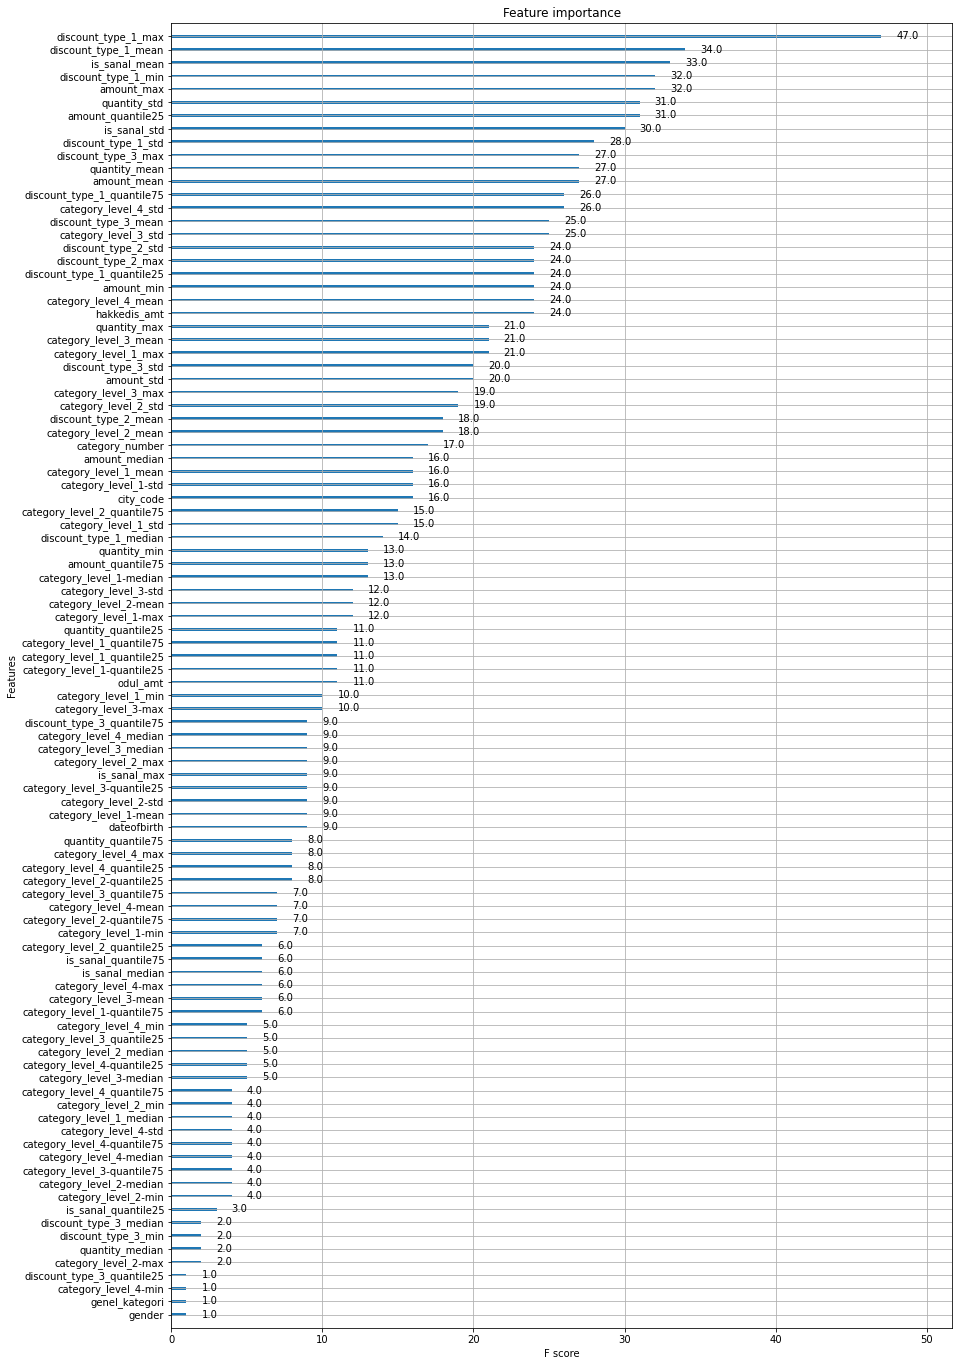

In [32]:
xgbc_final = XGBClassifier(**trial.params)
xgbc_final.fit(X, y)

plt.rcParams["figure.figsize"] = (14, 24)
plot_importance(xgbc_final)
plt.show()

# PREPARE AND PREDICT TEST DATA

In [33]:
test

,individualnumber,category_number,hakkedis_amt,odul_amt
0,95812936,9029,38.0,3.0
1,23929570,9012,28.0,2.0
2,95948115,9019,21.0,2.0
3,100898513,9035,48.0,4.0
4,12769156,9015,26.0,3.0
...,...,...,...,...
13231,93418529,9049,32.0,3.0
13232,97397069,9018,20.0,2.0
13233,95212479,9046,85.0,8.0
13234,93406449,9032,39.0,3.0


In [34]:
test_c = pd.merge(test, customer, how="left")
test_c

,individualnumber,category_number,hakkedis_amt,odul_amt,gender,city_code,dateofbirth
0,95812936,9029,38.0,3.0,E,10.0,1995.0
1,23929570,9012,28.0,2.0,E,34.0,1974.0
2,95948115,9019,21.0,2.0,E,67.0,1967.0
3,100898513,9035,48.0,4.0,K,51.0,1978.0
4,12769156,9015,26.0,3.0,K,34.0,1970.0
...,...,...,...,...,...,...,...
13231,93418529,9049,32.0,3.0,E,38.0,1979.0
13232,97397069,9018,20.0,2.0,E,9.0,1993.0
13233,95212479,9046,85.0,8.0,E,NaN,1962.0
13234,93406449,9032,39.0,3.0,E,78.0,1966.0


In [35]:
test_c_gk = pd.merge(test_c, genel_kategoriler, how="left")
test_c_gk

,individualnumber,category_number,hakkedis_amt,odul_amt,gender,city_code,dateofbirth,genel_kategori
0,95812936,9029,38.0,3.0,E,10.0,1995.0,kisisel_bakim
1,23929570,9012,28.0,2.0,E,34.0,1974.0,gida
2,95948115,9019,21.0,2.0,E,67.0,1967.0,gida
3,100898513,9035,48.0,4.0,K,51.0,1978.0,gida
4,12769156,9015,26.0,3.0,K,34.0,1970.0,gida
...,...,...,...,...,...,...,...,...
13231,93418529,9049,32.0,3.0,E,38.0,1979.0,diger
13232,97397069,9018,20.0,2.0,E,9.0,1993.0,gida
13233,95212479,9046,85.0,8.0,E,NaN,1962.0,gida
13234,93406449,9032,39.0,3.0,E,78.0,1966.0,kisisel_bakim


In [36]:
test_c_gk = pd.merge(test_c_gk, pg_grpd_agg, how = "left")
test_c_gk

,individualnumber,category_number,hakkedis_amt,odul_amt,gender,city_code,dateofbirth,genel_kategori,category_level_1-min,category_level_1-quantile25,...,category_level_3-max,category_level_3-mean,category_level_3-std,category_level_4-min,category_level_4-quantile25,category_level_4-median,category_level_4-quantile75,category_level_4-max,category_level_4-mean,category_level_4-std
0,95812936,9029,38.0,3.0,E,10.0,1995.0,kisisel_bakim,220,225.00,...,35,20.250000,9.385739,10,10.00,20.0,26.25,40,20.750000,10.036119
1,23929570,9012,28.0,2.0,E,34.0,1974.0,gida,125,131.00,...,60,24.977273,17.153871,10,13.75,20.0,31.25,50,22.863636,11.488297
2,95948115,9019,21.0,2.0,E,67.0,1967.0,gida,130,300.00,...,35,13.640288,5.602804,10,12.00,15.0,27.50,70,22.683453,15.735603
3,100898513,9035,48.0,4.0,K,51.0,1978.0,gida,300,300.00,...,30,12.711009,2.581706,10,11.00,14.0,18.00,39,15.911315,6.371940
4,12769156,9015,26.0,3.0,K,34.0,1970.0,gida,130,130.25,...,40,22.454545,9.490483,10,10.00,11.0,18.75,25,14.181818,5.197402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13231,93418529,9049,32.0,3.0,E,38.0,1979.0,diger,410,410.00,...,80,27.808383,18.157291,1,13.00,21.0,36.00,95,28.407186,22.447670
13232,97397069,9018,20.0,2.0,E,9.0,1993.0,gida,131,131.00,...,10,10.000000,0.000000,10,18.75,25.0,35.00,40,25.416667,10.757309
13233,95212479,9046,85.0,8.0,E,NaN,1962.0,gida,340,340.00,...,90,31.857143,23.731155,10,10.00,11.0,12.00,15,11.071429,1.094405
13234,93406449,9032,39.0,3.0,E,78.0,1966.0,kisisel_bakim,210,220.00,...,30,18.387097,7.232692,10,15.00,20.0,30.00,45,22.838710,10.683622


In [37]:
test = pd.merge(test_c_gk, ca_th_ts_grpd_agg, how = "left", on = "individualnumber")
test

,individualnumber,category_number,hakkedis_amt,odul_amt,gender,city_code,dateofbirth,genel_kategori,category_level_1-min,category_level_1-quantile25,...,discount_type_2_max,discount_type_2_mean,discount_type_2_std,discount_type_3_min,discount_type_3_quantile25,discount_type_3_median,discount_type_3_quantile75,discount_type_3_max,discount_type_3_mean,discount_type_3_std
0,95812936,9029,38.0,3.0,E,10.0,1995.0,kisisel_bakim,220,225.00,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000
1,23929570,9012,28.0,2.0,E,34.0,1974.0,gida,125,131.00,...,41.00,4.491538,11.477047,0.0,0.0,0.0,0.0,15.16,1.644615,4.292209
2,95948115,9019,21.0,2.0,E,67.0,1967.0,gida,130,300.00,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000
3,100898513,9035,48.0,4.0,K,51.0,1978.0,gida,300,300.00,...,14.95,0.256494,1.750326,0.0,0.0,0.0,0.0,14.95,0.817273,2.555378
4,12769156,9015,26.0,3.0,K,34.0,1970.0,gida,130,130.25,...,20.00,0.515165,2.370690,0.0,0.0,0.0,0.0,39.16,0.883599,3.433714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13231,93418529,9049,32.0,3.0,E,38.0,1979.0,diger,410,410.00,...,11.40,0.375962,1.466378,0.0,0.0,0.0,0.0,15.27,0.883846,2.581237
13232,97397069,9018,20.0,2.0,E,9.0,1993.0,gida,131,131.00,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,2.31,0.105000,0.492494
13233,95212479,9046,85.0,8.0,E,NaN,1962.0,gida,340,340.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13234,93406449,9032,39.0,3.0,E,78.0,1966.0,kisisel_bakim,210,220.00,...,6.00,0.501667,1.447660,0.0,0.0,0.0,0.0,55.96,2.823333,11.439543


In [38]:
X_test = test.drop(["individualnumber"], axis = 1)
X_test

,category_number,hakkedis_amt,odul_amt,gender,city_code,dateofbirth,genel_kategori,category_level_1-min,category_level_1-quantile25,category_level_1-median,...,discount_type_2_max,discount_type_2_mean,discount_type_2_std,discount_type_3_min,discount_type_3_quantile25,discount_type_3_median,discount_type_3_quantile75,discount_type_3_max,discount_type_3_mean,discount_type_3_std
0,9029,38.0,3.0,E,10.0,1995.0,kisisel_bakim,220,225.00,225.0,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000
1,9012,28.0,2.0,E,34.0,1974.0,gida,125,131.00,131.0,...,41.00,4.491538,11.477047,0.0,0.0,0.0,0.0,15.16,1.644615,4.292209
2,9019,21.0,2.0,E,67.0,1967.0,gida,130,300.00,302.0,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000
3,9035,48.0,4.0,K,51.0,1978.0,gida,300,300.00,300.0,...,14.95,0.256494,1.750326,0.0,0.0,0.0,0.0,14.95,0.817273,2.555378
4,9015,26.0,3.0,K,34.0,1970.0,gida,130,130.25,131.0,...,20.00,0.515165,2.370690,0.0,0.0,0.0,0.0,39.16,0.883599,3.433714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13231,9049,32.0,3.0,E,38.0,1979.0,diger,410,410.00,425.0,...,11.40,0.375962,1.466378,0.0,0.0,0.0,0.0,15.27,0.883846,2.581237
13232,9018,20.0,2.0,E,9.0,1993.0,gida,131,131.00,131.0,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,2.31,0.105000,0.492494
13233,9046,85.0,8.0,E,NaN,1962.0,gida,340,340.00,340.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13234,9032,39.0,3.0,E,78.0,1966.0,kisisel_bakim,210,220.00,220.0,...,6.00,0.501667,1.447660,0.0,0.0,0.0,0.0,55.96,2.823333,11.439543


In [39]:
lbl = LabelEncoder() 
X_test['gender'] = lbl.fit_transform(X_test['gender'].astype(str))
X_test['genel_kategori'] = lbl.fit_transform(X_test['genel_kategori'].astype(str))  
X_test

,category_number,hakkedis_amt,odul_amt,gender,city_code,dateofbirth,genel_kategori,category_level_1-min,category_level_1-quantile25,category_level_1-median,...,discount_type_2_max,discount_type_2_mean,discount_type_2_std,discount_type_3_min,discount_type_3_quantile25,discount_type_3_median,discount_type_3_quantile75,discount_type_3_max,discount_type_3_mean,discount_type_3_std
0,9029,38.0,3.0,0,10.0,1995.0,4,220,225.00,225.0,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000
1,9012,28.0,2.0,0,34.0,1974.0,1,125,131.00,131.0,...,41.00,4.491538,11.477047,0.0,0.0,0.0,0.0,15.16,1.644615,4.292209
2,9019,21.0,2.0,0,67.0,1967.0,1,130,300.00,302.0,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000
3,9035,48.0,4.0,1,51.0,1978.0,1,300,300.00,300.0,...,14.95,0.256494,1.750326,0.0,0.0,0.0,0.0,14.95,0.817273,2.555378
4,9015,26.0,3.0,1,34.0,1970.0,1,130,130.25,131.0,...,20.00,0.515165,2.370690,0.0,0.0,0.0,0.0,39.16,0.883599,3.433714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13231,9049,32.0,3.0,0,38.0,1979.0,0,410,410.00,425.0,...,11.40,0.375962,1.466378,0.0,0.0,0.0,0.0,15.27,0.883846,2.581237
13232,9018,20.0,2.0,0,9.0,1993.0,1,131,131.00,131.0,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,2.31,0.105000,0.492494
13233,9046,85.0,8.0,0,NaN,1962.0,1,340,340.00,340.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13234,9032,39.0,3.0,0,78.0,1966.0,4,210,220.00,220.0,...,6.00,0.501667,1.447660,0.0,0.0,0.0,0.0,55.96,2.823333,11.439543


In [40]:
y_test_pred = xgbc_final.predict(X_test)

# CREATING SUBMISSION

In [41]:
submission = pd.DataFrame({"individualnumber":test["individualnumber"]})
submission['response'] = y_test_pred
submission.response = submission.response.astype(int)
submission

,individualnumber,response
0,95812936,0
1,23929570,0
2,95948115,0
3,100898513,0
4,12769156,0
...,...,...
13231,93418529,0
13232,97397069,0
13233,95212479,0
13234,93406449,0


In [42]:
submission.to_csv(f"Submission-{time.strftime('%d - %H-%M-%S')}.csv", index=False)